# Integrating a Tool within a ChatBot

### Setting up Environment

In [25]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_core.messages import HumanMessage, AIMessage


### Initializing our LLM Model

In [26]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= "gemma2-9b-it")

### Defining a tool for our LLM

In [27]:
from langchain.tools import tool

@tool
def add(a:int, b:int)->int:
    """Add two numbers"""
    return a + b

### Binding the tool to our LLM

In [28]:
# binding tool with LLM 
llm_with_tools= llm.bind_tools([add])
tool_call = llm_with_tools.invoke([HumanMessage(content= f"What is 2 plus 2", name="Sujit")])
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'dzm0h94x0',
  'type': 'tool_call'}]

### Defining State for graph

In [29]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]


### Defining a Toolnode

In [30]:
# chatbot node functionality
def llm_tool(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

### building our graph

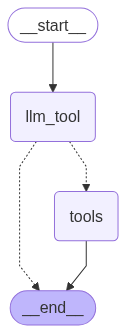

In [31]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
tools = [add]
builder = StateGraph(State)

# add nodes
builder.add_node("llm_tool", llm_tool)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    tools_condition
)
builder.add_edge("tools", END)
# builder.add_edge("llm_tool", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the Graph 

In [32]:
# invocation
messagess = graph.invoke({"messages":[HumanMessage(content = "what is 2 plus 2?")]})

for messages in messagess["messages"]:
    messages.pretty_print()

================================ Human Message =================================

what is 2 plus 2?
================================== Ai Message ==================================
Tool Calls:
  add (5favck25z)
 Call ID: 5favck25z
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [33]:
messagess = graph.invoke({"messages":"Good morning"})

for messages in messagess["messages"]:
    messages.pretty_print()

================================ Human Message =================================

Good morning
================================== Ai Message ==================================
Tool Calls:
  add (hehnsbzrs)
 Call ID: hehnsbzrs
  Args:
    a: 1
    b: 2
================================= Tool Message =================================
Name: add

3
